In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

In [36]:
import numpy as np

In [37]:
import sys
sys.path.append('..')

from my_code import functions as f

# Data

In [38]:
file_path = '../data/energies/Trial/Strings_Energies.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
angles_list = np.array([f.string_to_numbers(string) for string in string_list])

In [39]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

In [40]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Quantum node

In [41]:
import pennylane as qml

n_qubits = 12
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [42]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In [43]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Classical model

In [44]:
input_dim = input_data.size(1)

layers =  [nn.Linear(input_dim*1, input_dim*2), nn.ReLU()]
layers += [nn.Linear(input_dim*2, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*2), nn.ReLU()] 
layers += [nn.Linear(input_dim*2, input_dim*1), nn.ReLU()] 
layers += [qlayer] 
layers += [nn.Linear(input_dim*1, input_dim*1), nn.ReLU()] 
layers += [nn.Linear(input_dim*1, 1          ), nn.ReLU()] 
Net = nn.Sequential(*layers)

In [45]:
# # Define the neural network architecture
# class Net(nn.Module):
#     def __init__(self, input_dim):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, 64)
#         self.fc5 = nn.Linear(64, 64)
#         self.fc6 = nn.Linear(64, 32)
#         self.fc7 = nn.Linear(32, 1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = torch.relu(self.fc5(x))
#         x = torch.relu(self.fc6(x))
#         x = self.fc7(x)
#         return x

In [46]:
# Create an instance of the network
model = Net

In [47]:
# from torchsummary import summary
# #draw the model
# summary(model, (input_dim,))

In [48]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop
num_epochs = 100
batch_size = 32

losses = []
losses_epochs = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()))

    losses_epochs.append(criterion(input_data, target_data).item())

    # Print the loss for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


- Epoch [1/100], i: [0/900], Loss: 26.5857
- Epoch [1/100], i: [32/900], Loss: 26.3064
- Epoch [1/100], i: [64/900], Loss: 15.1896
- Epoch [1/100], i: [96/900], Loss: 16.9189
- Epoch [1/100], i: [128/900], Loss: 27.4067
- Epoch [1/100], i: [160/900], Loss: 23.2274
- Epoch [1/100], i: [192/900], Loss: 18.1723
- Epoch [1/100], i: [224/900], Loss: 20.6246
- Epoch [1/100], i: [256/900], Loss: 25.0097
- Epoch [1/100], i: [288/900], Loss: 25.1773
- Epoch [1/100], i: [320/900], Loss: 16.8852
- Epoch [1/100], i: [352/900], Loss: 27.6851
- Epoch [1/100], i: [384/900], Loss: 26.9340
- Epoch [1/100], i: [416/900], Loss: 21.3183
- Epoch [1/100], i: [448/900], Loss: 29.5618
- Epoch [1/100], i: [480/900], Loss: 27.8370
- Epoch [1/100], i: [512/900], Loss: 22.5791
- Epoch [1/100], i: [544/900], Loss: 22.0955
- Epoch [1/100], i: [576/900], Loss: 21.1550
- Epoch [1/100], i: [608/900], Loss: 21.2577
- Epoch [1/100], i: [640/900], Loss: 16.3501
- Epoch [1/100], i: [672/900], Loss: 24.2385
- Epoch [1/100]

d:\Raul\Programs\envs\PennyLane\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([900, 1])) that is different to the input size (torch.Size([900, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


- Epoch [2/100], i: [0/900], Loss: 30.8139
- Epoch [2/100], i: [32/900], Loss: 21.2174
- Epoch [2/100], i: [64/900], Loss: 25.6078
- Epoch [2/100], i: [96/900], Loss: 23.1270
- Epoch [2/100], i: [128/900], Loss: 22.1117
- Epoch [2/100], i: [160/900], Loss: 19.0795
- Epoch [2/100], i: [192/900], Loss: 20.6539
- Epoch [2/100], i: [224/900], Loss: 21.2985
- Epoch [2/100], i: [256/900], Loss: 21.3004
- Epoch [2/100], i: [288/900], Loss: 23.7997
- Epoch [2/100], i: [320/900], Loss: 24.5951
- Epoch [2/100], i: [352/900], Loss: 18.2464
- Epoch [2/100], i: [384/900], Loss: 14.7333
- Epoch [2/100], i: [416/900], Loss: 24.8253
- Epoch [2/100], i: [448/900], Loss: 21.4928
- Epoch [2/100], i: [480/900], Loss: 20.8882
- Epoch [2/100], i: [512/900], Loss: 22.9723
- Epoch [2/100], i: [544/900], Loss: 27.7344
- Epoch [2/100], i: [576/900], Loss: 20.3514
- Epoch [2/100], i: [608/900], Loss: 18.9017
- Epoch [2/100], i: [640/900], Loss: 19.6025
- Epoch [2/100], i: [672/900], Loss: 15.9711
- Epoch [2/100]

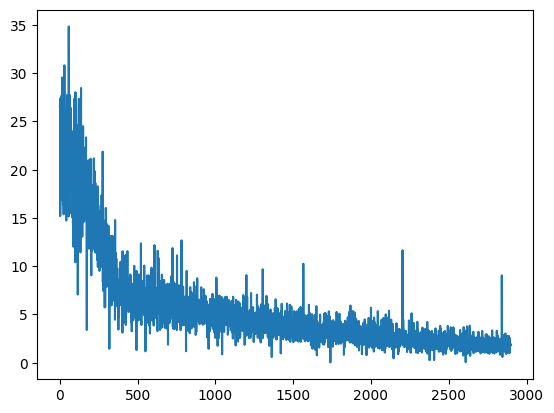

In [49]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [1]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, target: {:.3f}, output: {:.3f}, loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))
    print('')

print('Average loss: {:.3f}'.format(avg_loss))

NameError: name 'input_validation' is not defined